# Running Multiple Ori CNN with Cloud Data (Layer 2/3)

November 4th, 2024

In [1]:
import sys
import os

myhost = os.uname()[1]
print("Running on Computer: [%s]" %myhost)

sys.path.insert(0, '/home/ifernand/Code/') 
dirname = '/home/ifernand/Cloud_SynthData_Proj'

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import io as sio
import torch
import time
import h5py

# NDN tools
import NDNT
import NDNT.utils as utils
from NDNT.modules.layers import *
from NDNT.networks import *
import NDNT.NDN as NDN
from NTdatasets.conway.synthcloud_datasets import SimCloudData
from NTdatasets.generic import GenericDataset
from ColorDataUtils.multidata_utils import MultiExperiment
import ColorDataUtils.ConwayUtils as CU
from ColorDataUtils import readout_fit
from ColorDataUtils.simproj_utils import *
from NDNT.utils import fit_lbfgs, fit_lbfgs_batch
from NDNT.utils import imagesc   
from NDNT.utils import ss

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

%load_ext autoreload
%autoreload 2

Running on Computer: [sc]
Invoking __init__.py for NDNT.utils


## Load Data

In [2]:
# Load RF center and cell key
out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3.hdf5' #'data/cloud_data_stim_dim80_robs_sqrad_0.1.hdf5'
with h5py.File(out_file, 'r') as f:
    x_pos = f['x_pos'][:]
    y_pos = f['y_pos'][:]
    cell_key = [str(f['cell_key'][:][i], encoding='utf-8') for i in range(x_pos.shape[0])]
    file_start_pos = list(f['file_start_pos'][:])

In [3]:
# Load Orientation info
ori_dict = np.load('data/V1_neuron_orientation_in_deg_and_orientation_selection_sqrad_0.3_GQM.pkl', allow_pickle=True)
L23_thetas = np.concatenate((ori_dict['thetas']['V1_Exc_L2/3'], ori_dict['thetas']['V1_Inh_L2/3']))
L23_osis = np.concatenate((ori_dict['osis']['V1_Exc_L2/3'], ori_dict['osis']['V1_Inh_L2/3']))
print(L23_thetas.shape)
print(L23_osis.shape)

(697,)
(697,)


In [4]:
# cell specific indices
LGN_idx = [i for i, val in enumerate(cell_key) if val == 'X_ON' or val == 'X_OFF']
V1_idx  = [i for i, val in enumerate(cell_key) if val == 'V1_Exc_L4' or val == 'V1_Inh_L4' or val == 'V1_Exc_L2/3' or val == 'V1_Inh_L2/3']
L23_idx  = [i for i, val in enumerate(cell_key) if val == 'V1_Exc_L2/3' or val == 'V1_Inh_L2/3']
print('LGN cells:', len(LGN_idx))
print('V1 cells:', len(V1_idx))
print('L2/3 cells:', len(L23_idx))

LGN cells: 214
V1 cells: 1491
L2/3 cells: 697


In [5]:
L23_cell_key = [cell_key[i] for i in L23_idx]
L23_exc_idx = [i for i, val in enumerate(L23_cell_key) if val == 'V1_Exc_L2/3']
L23_inh_idx = [i for i, val in enumerate(L23_cell_key) if val == 'V1_Inh_L2/3']

In [6]:
#out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3.hdf5'
start    = time.time()
data     = SimCloudData(file_name=out_file, down_sample=2, cell_idx=L23_idx, num_lags=11)
end      = time.time()
print('CPU Time', end-start, 'sec')

CPU Time 48.99210333824158 sec


In [7]:
stim_dims = data.stim_dims
num_lags = data.num_lags
L  = stim_dims[1]
NC = data[0]['robs'].shape[1]
NT = data.NT
print('stim_dims =', stim_dims)
print('num_lags =', num_lags)
print('L =', L)
print('Number of cells', NC)
print('Number of time points', NT)

stim_dims = [1, 60, 60, 1]
num_lags = 11
L = 60
Number of cells 697
Number of time points 510000


In [8]:
pxl_x_pos, pxl_y_pos = deg2pxl(x_pos[L23_idx], y_pos[L23_idx], L, down_sample=2)
mu0s = utils.pixel2grid(np.stack((pxl_x_pos,pxl_y_pos),axis=1), L=L)
print('Spatial mu0:', mu0s.shape)

Spatial mu0: (697, 2)


## Degree to Qum

In [9]:
def degrees2mu(theta_deg, angles, continuous=True, max_angle=180 ):
    """
    Converts degrees into mu-values. If to_output=True, outputs to an array, and otherwise
    stores in the Qmu variable. It detects whether half-circle of full circle using stored angle values
        
    Args:
        theta_deg (np array): array of angles in degrees into mu values, based on 180 or 360 deg wrap-around
        continuous (Boolean): whether to convert to continuous angle or closest "integer" mu value (def True, continuous)
        max_angle: maximum angle represented in OriConv layers (default 180, but could be 360)
    Returns:
        Qmus: as numpy-array, if to_output is set to True, otherwise, nothing 
    """
    num_angles = len(angles)

    # convert inputs to np.array
    if not isinstance(theta_deg, np.ndarray):
        theta_deg = np.array(theta_deg, dtype=np.float32)
    if not continuous:
        dQ = max_angle/num_angles
        theta_deg = dQ * np.round(theta_deg/dQ)
    theta_deg = (theta_deg%max_angle)  # map between 0 and max_angle

    mu_offset = 1/num_angles # first bin at 0 degrees is actually a shifted mu value (not right at edge)
    Qmus = (theta_deg-max_angle/2) / (max_angle/2) + mu_offset
    Qmus[Qmus <= -1] += 2
    Qmus[Qmus > 1] += -2
    
    return Qmus

In [10]:
angles = np.arange(0, 180, 30).astype(int)
Qmu0s = degrees2mu(L23_thetas, angles)
print('Angle mu0:', Qmu0s.shape)

Angle mu0: (697,)


## Ori CNN - Keep Layer 4 Core Fixed

In [11]:
# Adam Parameters
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=3,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay=0.2, accumulated_grad_batches=3)
adam_pars['device'] = device

In [12]:
L4_cnn = NDN.load_model_zip('models/1016_three_layer_model_ORICONV_CNN_L4_None_maxreg.ndn')
L4_cnn.block_sample = True
L4_cnn.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([3610, 2])
  Layer 1:
      weight: torch.Size([722, 12])
  Layer 2:
      NOT FIT: weight: torch.Size([1, 1])
  Layer 3:
      weight: torch.Size([300, 8])
Network 1:
  Layer 0:
      weight: torch.Size([20, 794])
      bias: torch.Size([794])
      mu: torch.Size([794, 2])
      sigma: torch.Size([794, 1])
      Qmu: torch.Size([794, 1])
      Qsigma: torch.Size([794, 1])


In [47]:
XTreg = 0.0001
Xreg0 = 1.0 # d2/dx
Creg0 = 0.05 # center

Xreg1 = 0.1 # d2/dx
Creg1 = 0.001 # center

MaxReg = None

angle_mode = 'nearest' # 'bilinear'

num_subs = [2, 12, 8, 8]
fws = [19, 19, 5, 5]

NQ = len(angles)
print(NQ, angles)

# LGN LAYER
clayersQ = [STconvLayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=num_subs[0], norm_type=1,
    filter_dims=[1,fws[0],fws[0],num_lags-1] , bias=False, NLtype='relu',
    padding='circular', output_norm='batch', window='hamming', initialize_center=True,
    reg_vals={'d2xt':XTreg, 'd2x':Xreg0, 'center': Creg0} )]

# PROJECTION LAYER
clayersQ.append(
    OriConvLayer.layer_dict(
        num_filters=num_subs[1], num_inh=num_subs[1]//2,
        filter_width=fws[1], NLtype='relu', norm_type=1,
        bias=False, output_norm='batch', window='hamming', padding='circular', initialize_center=True, 
        reg_vals={'d2x':Xreg1, 'center': Creg1}, angles=angles) )

# TIME SHIFT LAYER
clayersQ.append(TimeShiftLayer.layer_dict())

# REST
for ii in range(2,len(fws)):
    clayersQ.append(OriConvLayer.layer_dict( 
        num_filters=num_subs[ii], num_inh=num_subs[ii]//2, bias=False, norm_type=1, 
        filter_width=fws[ii], NLtype='relu',
        output_norm='batch', initialize_center=True, #window='hamming', 
        angles=angles) )
        
scaffold_netQ =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold3d', xstim_n='stim', layer_list=clayersQ, scaffold_levels=[1,3], num_lags_out=NQ)

readout_parsQ = ReadoutLayerQsample.layer_dict(
    num_filters=NC, NLtype='softplus', bias=True, pos_constraint=True,
    reg_vals={'max': MaxReg})

readout_netQ = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0], layer_list = [readout_parsQ], ffnet_type='readout')

6 [  0  30  60  90 120 150]


In [48]:
cnn = NDN(ffnet_list = [scaffold_netQ, readout_netQ], loss_type='poisson')
# Network 0: Initialize and fix filters
cnn.networks[0].layers[0].weight.data = deepcopy(L4_cnn.networks[0].layers[0].weight.data)
cnn.networks[0].layers[0].set_parameters(val=False)
cnn.networks[0].layers[1].weight.data = deepcopy(L4_cnn.networks[0].layers[1].weight.data)
cnn.networks[0].layers[1].set_parameters(val=False)
cnn.networks[0].layers[3].weight.data = deepcopy(L4_cnn.networks[0].layers[3].weight.data)
cnn.networks[0].layers[3].set_parameters(val=False)

# Network 1: set numu values
cnn.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
cnn.networks[1].layers[0].Qmu.data[:,0] = torch.tensor(Qmu0s, dtype=torch.float32)
cnn.networks[1].layers[0].fit_mus(True)
cnn.networks[1].layers[0].fit_Qmus(False)
cnn.networks[1].layers[0].Qsample_mode = angle_mode
cnn.block_sample = True

cnn.list_parameters()

  ReadoutLayer: fitting mus
  ReadoutLayer: not fitting Qmus
Network 0:
  Layer 0:
      NOT FIT: weight: torch.Size([3610, 2])
  Layer 1:
      NOT FIT: weight: torch.Size([722, 12])
  Layer 2:
      NOT FIT: weight: torch.Size([1, 1])
  Layer 3:
      NOT FIT: weight: torch.Size([300, 8])
  Layer 4:
      weight: torch.Size([200, 8])
Network 1:
  Layer 0:
      weight: torch.Size([20, 697])
      bias: torch.Size([697])
      mu: torch.Size([697, 2])
      sigma: torch.Size([697, 1])
      NOT FIT: Qmu: torch.Size([697, 1])
      NOT FIT: Qsigma: torch.Size([697, 1])


In [ ]:
cnn.fit(data, **adam_pars, verbose=True)

Model: M697_CsXXXX_X

GPU Available: True, GPU Used: True
Epoch 1: train loss 0.406450 val loss 0.346447
Epoch 2: train loss 0.358952 val loss 0.341708
Epoch 3: train loss 0.355547 val loss 0.340190
Epoch 4: train loss 0.354272 val loss 0.339159


In [ ]:
cnn.save_model_zip('models/1104_three_layer_model_ORICONV_CNN_10_6_units_L23.ndn')

In [19]:
LL = cnn.eval_models(data, data_inds=data.val_blks, device=device, batch_size=3, null_adjusted=True)
print('Log Likelyhood shape', LL.shape)

Eval models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:17<00:00,  1.99it/s]

Log Likelyhood shape (697,)


L23 Exc Mean LL: 0.27926162 L23 Inh Mean LL: 0.10489184


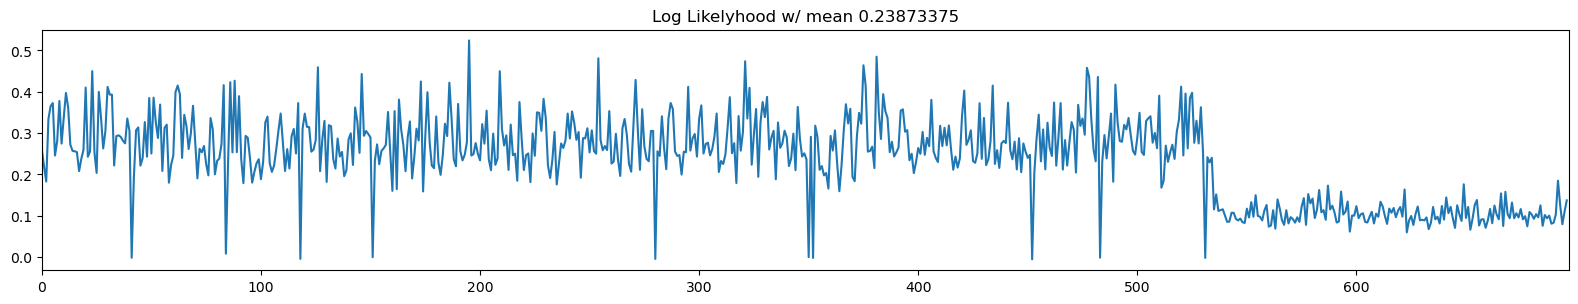

In [20]:
print('L23 Exc Mean LL:', np.mean(LL[L23_exc_idx]), 'L23 Inh Mean LL:', np.mean(LL[L23_inh_idx]))
ss()
#plt.plot([0,NC],[0,0], 'k')
plt.plot(LL)
plt.title('Log Likelyhood w/ mean '+str(np.mean(LL)))
plt.xlim([0,NC])
#plt.ylim([0,1])
plt.show()

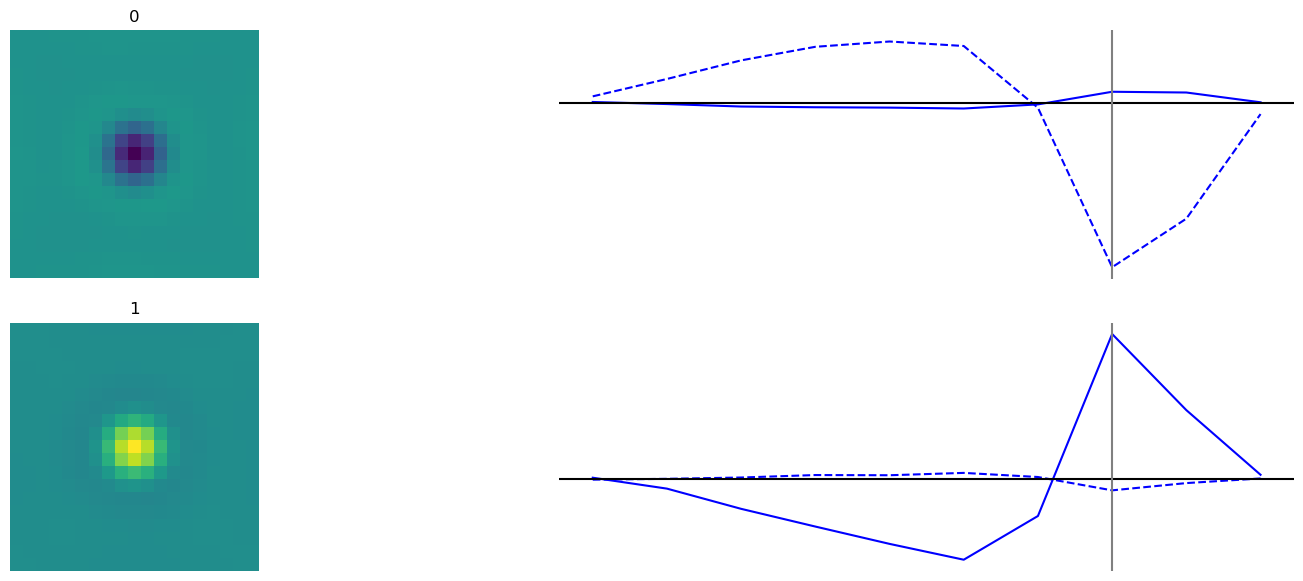

In [22]:
cnn.plot_filters()

In [24]:
filters1 = cnn.get_weights(ffnet_target=0,layer_target=1)
filters2 = cnn.get_weights(ffnet_target=0,layer_target=3)
ei_mask_layer1 = deepcopy(cnn.networks[0].layers[1]._ei_mask).detach().cpu().numpy()
ei_mask_layer2 = deepcopy(cnn.networks[0].layers[3]._ei_mask).detach().cpu().numpy()
print(filters1.shape)
print(filters2.shape)
print(ei_mask_layer1.shape)
print(ei_mask_layer2.shape)

(2, 19, 19, 12)
(12, 5, 5, 8)
(72,)
(48,)


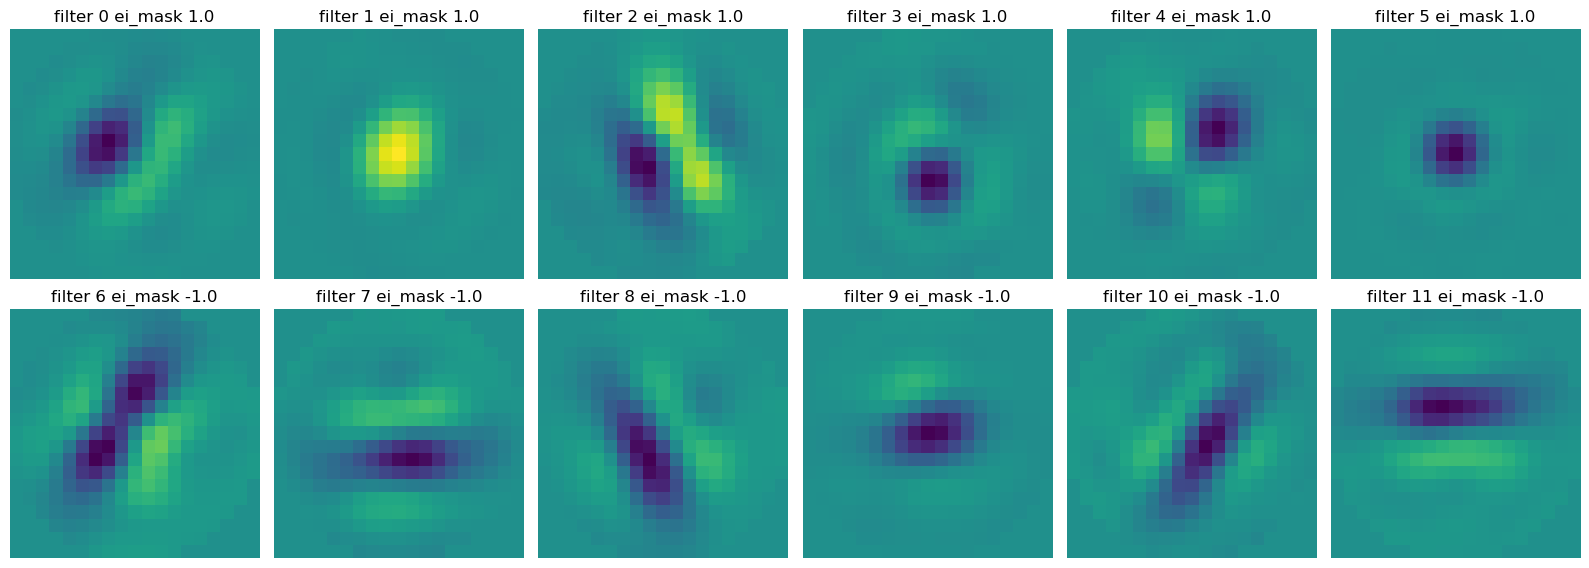

In [25]:
ss(2,6)
for i in range(12):
    plt.subplot(2,6,i+1)
    imagesc(filters1[0,:,:,i], balanced=True)
    plt.title('filter '+str(i)+' ei_mask '+str(ei_mask_layer1[i]))
    plt.axis('off')
plt.tight_layout()
#plt.savefig('/home/ifernand/Desktop/filters.png')
plt.show()

In [27]:
# Readout Weights (i.e. Barcodes)
full_ei_mask = np.concatenate((ei_mask_layer1[:filters1.shape[3]], ei_mask_layer2[:filters2.shape[3]]))
readout_w = cnn.get_weights(ffnet_target=1)
print(readout_w.shape)
print(full_ei_mask.shape)

(20, 697)
(20,)


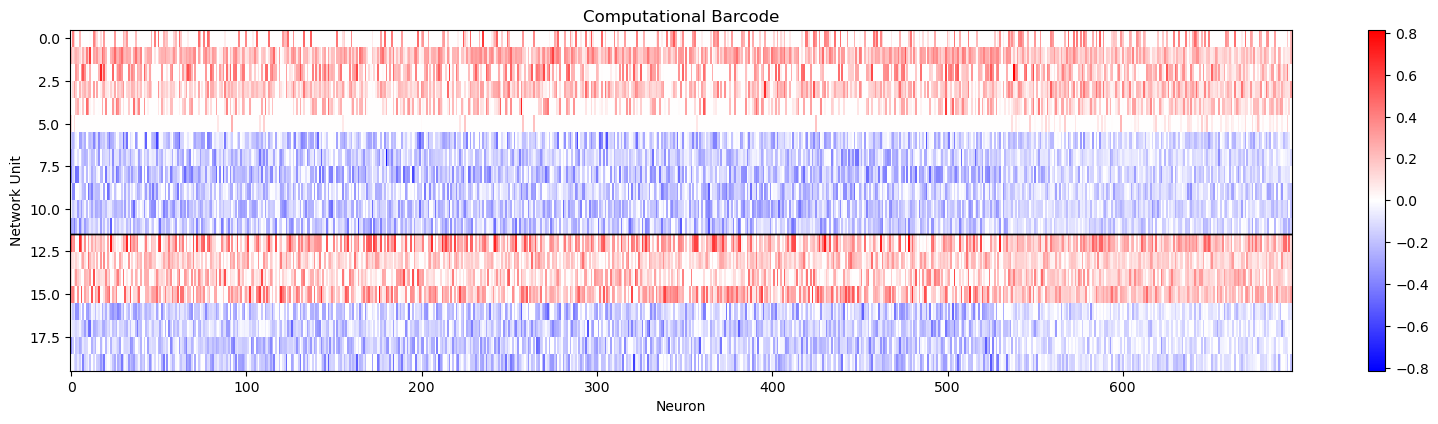

In [28]:
ss(rh=4)
imagesc((readout_w*full_ei_mask.reshape(full_ei_mask.shape[0],1)).T, cmap='bwr')
plt.axhline(y=ei_mask_layer1[:filters1.shape[3]].shape[0]-0.5, color='black', lw=1)
plt.axhline(y=ei_mask_layer1[:filters1.shape[3]].shape[0]-0.5, color='black', lw=1)
plt.title('Computational Barcode')
plt.ylabel('Network Unit')
plt.xlabel('Neuron')
plt.colorbar()

In [29]:
readout_similarity = cos_similarity(readout_w) #*full_ei_mask.reshape(full_ei_mask.shape[0],1))

Text(0.5, 1.0, 'Cos Similarity Matrix')

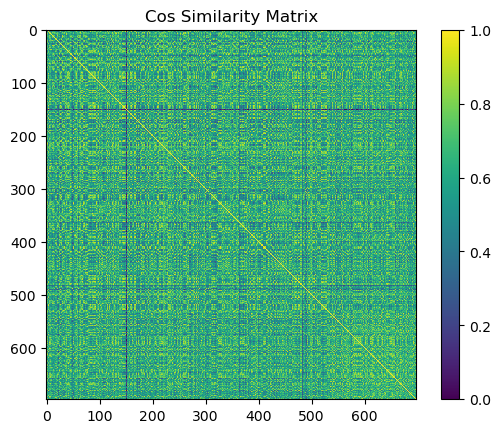

In [30]:
imagesc(readout_similarity)
plt.colorbar()
plt.clim(0,1)
#plt.axvline(x=L4_exc_idx[-1], color='black', lw=2)
#plt.axhline(y=L4_exc_idx[-1], color='black', lw=2)
plt.title('Cos Similarity Matrix')

In [31]:
unique_cos_sim = readout_similarity[np.triu_indices(NC, k = 1)]

In [32]:
L23_exc_readout_similarity = readout_similarity[L23_exc_idx,:]
L23_exc_readout_similarity = L23_exc_readout_similarity[:,L23_exc_idx]
L23_exc_unique_cos_sim = L23_exc_readout_similarity[np.triu_indices(len(L23_exc_idx), k = 1)]

L23_inh_readout_similarity = readout_similarity[L23_inh_idx,:]
L23_inh_readout_similarity = L23_inh_readout_similarity[:,L23_inh_idx]
L23_inh_unique_cos_sim = L23_inh_readout_similarity[np.triu_indices(len(L23_inh_idx), k = 1)]

inh_v_exc_cos_sim = readout_similarity[L23_inh_idx, :]
inh_v_exc_cos_sim = inh_v_exc_cos_sim[:, L23_exc_idx].reshape((len(L23_exc_idx)*len(L23_inh_idx)))

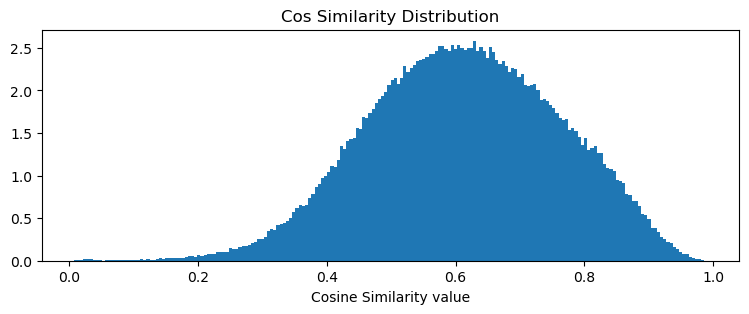

In [33]:
plt.figure(figsize=(9,3))
plt.hist(unique_cos_sim, bins=200, density=True)
plt.title('Cos Similarity Distribution')
plt.xlabel('Cosine Similarity value')
plt.show()

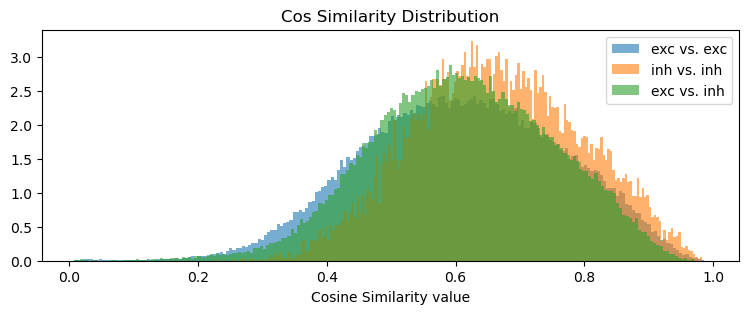

In [34]:
plt.figure(figsize=(9,3))
plt.hist(L23_exc_unique_cos_sim, bins=200, label='exc vs. exc', alpha=0.6, density=True)
plt.hist(L23_inh_unique_cos_sim, bins=200, label='inh vs. inh', alpha=0.6, density=True)
plt.hist(inh_v_exc_cos_sim, bins=200, label='exc vs. inh', alpha=0.6, density=True)
plt.title('Cos Similarity Distribution')
plt.xlabel('Cosine Similarity value')
plt.legend()
plt.show()

In [35]:
from sklearn import metrics
unique_mapping = {string: idx for idx, string in enumerate(set(L23_cell_key))}
integer_list = [unique_mapping[string] for string in L23_cell_key]

In [36]:
silhouette_score =  metrics.silhouette_score( readout_w.T, np.array(integer_list), metric="cosine", sample_size=NC)
print(silhouette_score)

0.024304153


In [37]:
filt_count = np.sum(readout_w > 0.001, axis=0)
filt_count_layer1 = np.sum(readout_w[:filters1.shape[3],:] > 0.001, axis=0)
filt_count_layer2 = np.sum(readout_w[filters1.shape[3]:,:] > 0.001, axis=0)
filt_count.shape

(697,)

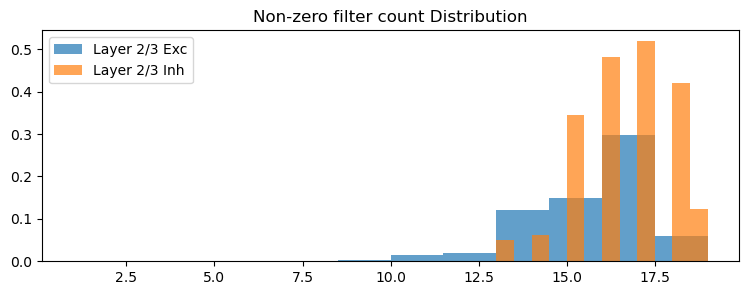

In [39]:
plt.figure(figsize=(9,3))
plt.hist(filt_count[L23_exc_idx] ,bins=12, label='Layer 2/3 Exc', alpha=0.7, density=True)
plt.hist(filt_count[L23_inh_idx] ,bins=12, label='Layer 2/3 Inh', alpha=0.7, density=True)
plt.title('Non-zero filter count Distribution')
plt.legend()
plt.show()

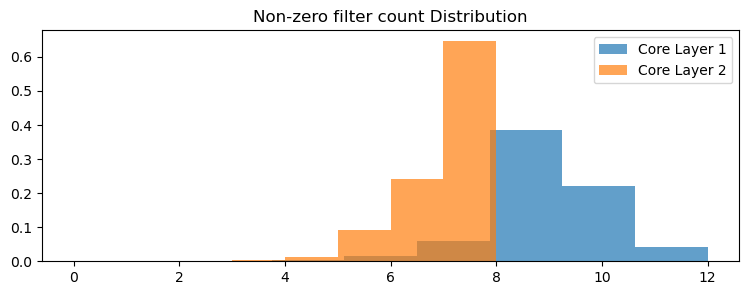

In [40]:
plt.figure(figsize=(9,3))
plt.hist(filt_count_layer1 ,bins=8, label='Core Layer 1', alpha=0.7, density=True)
plt.hist(filt_count_layer2 ,bins=8, label='Core Layer 2', alpha=0.7, density=True)
plt.title('Non-zero filter count Distribution')
plt.legend()
plt.show()

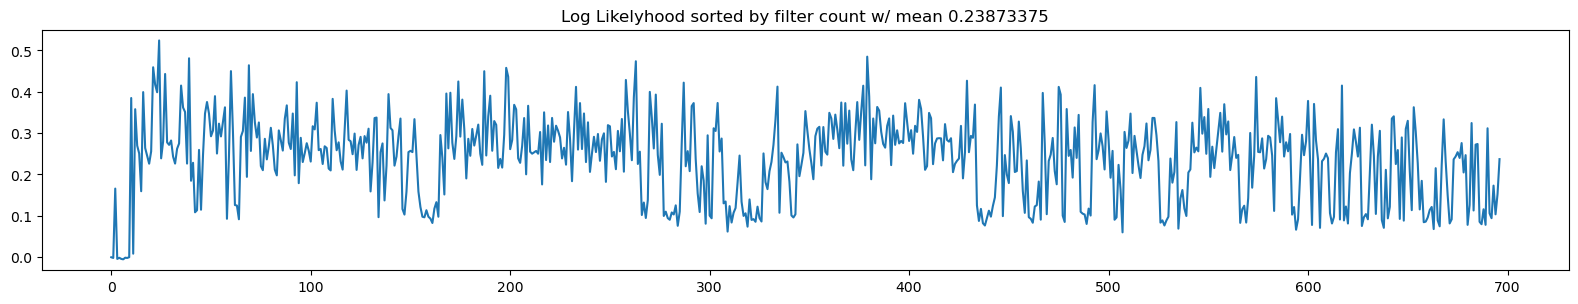

In [41]:
ss()
plt.plot(LL[np.argsort(filt_count)])
plt.title('Log Likelyhood sorted by filter count w/ mean '+str(np.mean(LL[np.argsort(filt_count)])))
plt.show()

In [42]:
L23_exc_cell_count = np.mean(readout_w[:,L23_exc_idx]*full_ei_mask.reshape(full_ei_mask.shape[0],1), axis=1) #np.mean(readout_w[:,L4_exc_idx], axis=1)
print(L23_exc_cell_count.shape)
L23_inh_cell_count = np.mean(readout_w[:,L23_inh_idx]*full_ei_mask.reshape(full_ei_mask.shape[0],1), axis=1) #np.mean(readout_w[:,L4_inh_idx], axis=1)
print(L23_inh_cell_count.shape)

(20,)
(20,)


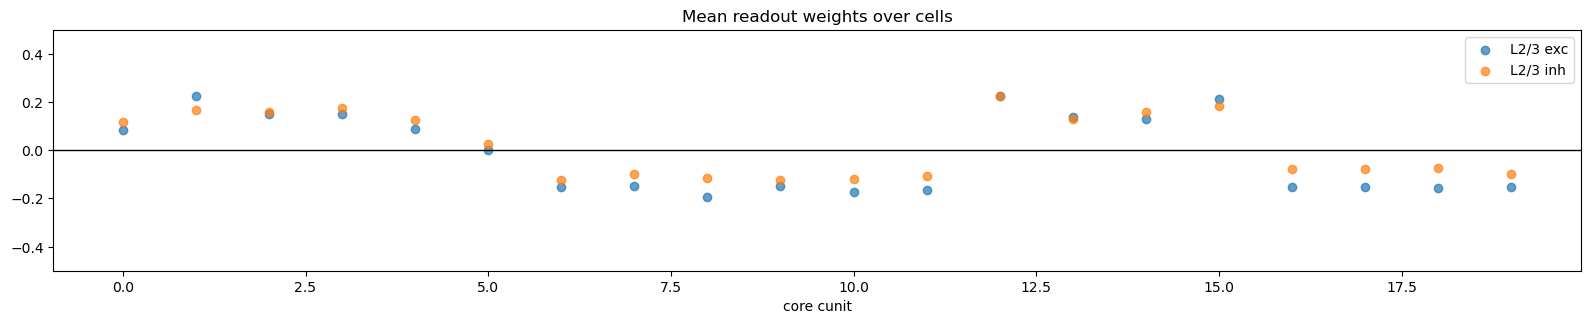

In [43]:
total_filters = filters1.shape[3]+filters2.shape[3]
ss()
plt.scatter(np.arange(total_filters), L23_exc_cell_count, label='L2/3 exc', alpha=0.7)
plt.scatter(np.arange(total_filters), L23_inh_cell_count, label='L2/3 inh', alpha=0.7)
plt.axhline(y=0, color='black', lw=1)
plt.title('Mean readout weights over cells')
plt.xlabel('core cunit')
plt.ylim([-0.5,0.5])
plt.legend()

In [44]:
weight_dist_layer2 = np.zeros((filters2.shape[-1],filters2.shape[0]))
for i in range(filters2.shape[-1]):
    weight_dist_layer2[i,:] = np.mean((filters2[:,:,:,i]*filters2[:,:,:,i]), axis=(1,2))
print(weight_dist_layer2.shape)

(8, 12)


Text(162.59722222222223, 0.5, 'Mean Squared Layer 2 Weights')

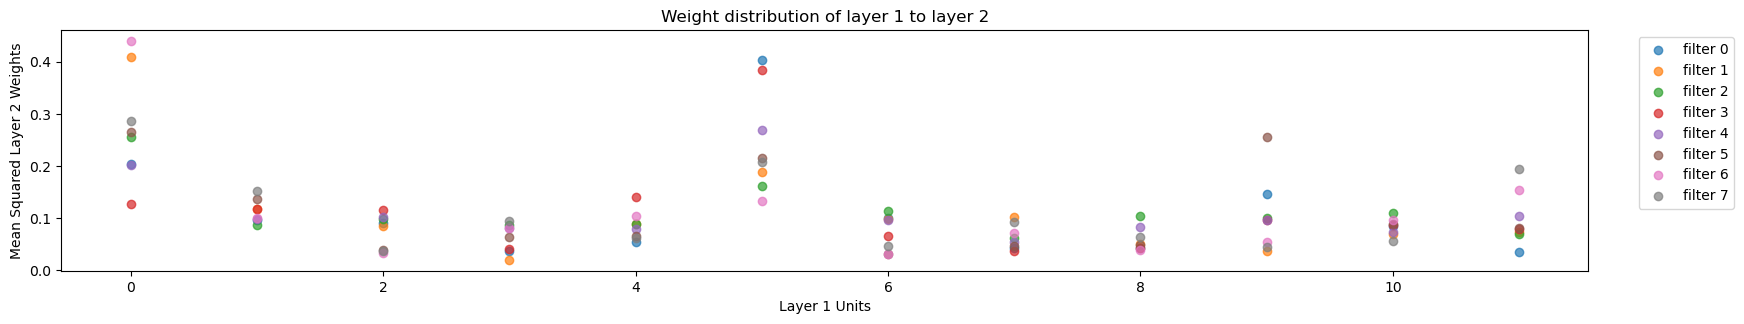

In [45]:
ss()
for i in range(filters2.shape[-1]):
    plt.scatter(np.arange(filters2.shape[0]),weight_dist_layer2[i,:], label='filter '+str(i), alpha=0.7)
plt.legend(loc='upper right',bbox_to_anchor=(1.1, 1.0))
plt.title("Weight distribution of layer 1 to layer 2")
plt.xlabel('Layer 1 Units')
plt.ylabel('Mean Squared Layer 2 Weights')

Text(162.59722222222223, 0.5, 'Mean Squared Layer 2 Weights')

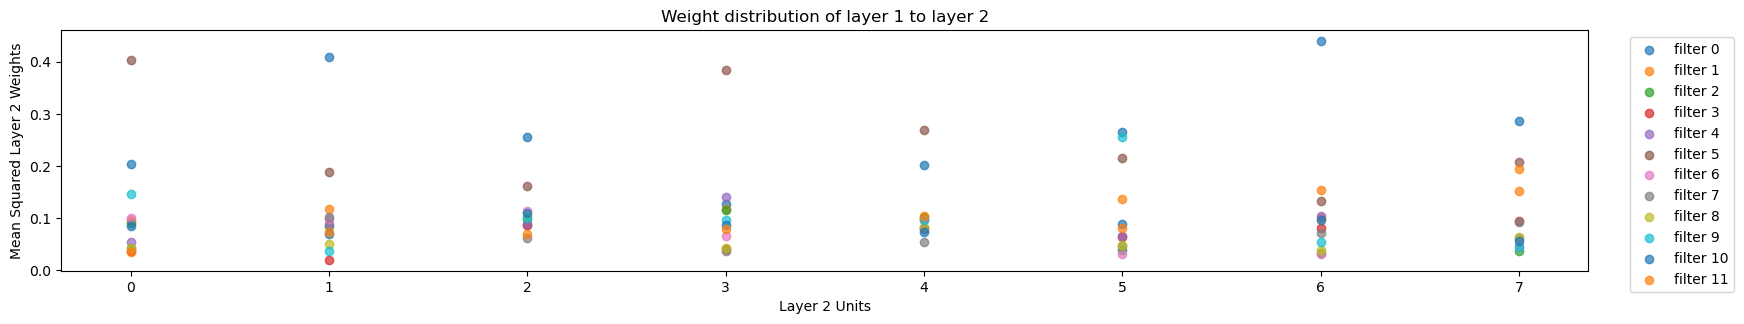

In [46]:
ss()
for i in range(filters2.shape[0]):
    plt.scatter(np.arange(filters2.shape[-1]),weight_dist_layer2[:,i], label='filter '+str(i), alpha=0.7)
plt.legend(loc='upper right',bbox_to_anchor=(1.1, 1.0))
plt.title("Weight distribution of layer 1 to layer 2")
plt.xlabel('Layer 2 Units')
plt.ylabel('Mean Squared Layer 2 Weights')